# 3_Gaussian_Mixture_Model_with_EM_Algorithm
- Synthetic Cluster Data
- EM algorithm

## 1. Settings

### 1) Import required libraries

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
torch.manual_seed(777)
np.random.seed(777)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

## 2. Data

### 1) Sampling data from Gaussian distribution

In [3]:
def sample(mu, var, nb_samples=500):
    out =[torch.normal(mu, var.sqrt()).unsqueeze(0) for i in range(nb_samples)]
    return torch.cat(out)

# generate some clusters
cluster1 = sample(torch.Tensor([7, 9]), torch.Tensor([1, 6]))           # (500,2)
cluster2 = sample(torch.Tensor([1.5, 7.5]), torch.Tensor([2, 2]))       # (500,2)
cluster3 = sample(torch.Tensor([2.5, 1.5]),   torch.Tensor([.8, 1]))    # (500,2) 

In [4]:
#cluster1

### 2) Plot Data

torch.Size([1500, 2])


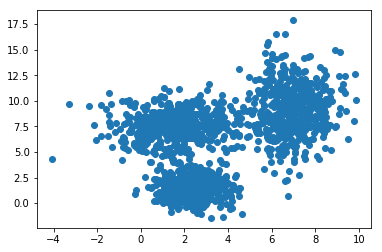

In [5]:
# create dataset by combining the clusters.
data = torch.cat([cluster1, cluster2, cluster3])
print(data.size())
plt.scatter(data[:,0].numpy(), data[:,1].numpy())

## 3. Gaussian Mixture Model with EM algorithm

### 1) Initialize Parameters

In [6]:
N = data.size(0) # number of data
M = data.size(1) # dimension of data, ( 2 )
K = 3            # number of Cluster  ( Our Assumption == 3 )

#initialization 
idxs = torch.from_numpy(np.random.choice(N, K, replace=False)) # randomly pickup data K data IDs
idxs = idxs.type(torch.LongTensor)
mu = data[idxs]                                                # initial mu       (3, 2)
var = torch.ones(K,M)                                          # initial variance (3, 2)
phi = torch.ones(K)/K                                          # initial parameter for priors (3 )

### 2) multivariate Gaussian likelihoods function

The p.d.f. of the multivariate gaussian is

### $ p(x;\mu, \sigma)=\frac{1}{\sqrt{2\pi|\Sigma|} }\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right) $.

We are considering diagonal covariance matrice $I\sigma^2=\sum$. 

1) the determinant is

### $ |\Sigma| = \prod_{j=1}^{N}\sigma_{j}^{2} $

2) the inverse of covariance matrices is 

### $ Tr(\Sigma^{-1}) = \left[\sigma_1^{-2}, ..., \sigma_N^{-2}\right] $

3) the exponent is simplified to 

### $-\frac{1}{2}\left(\left(x-\mu\right)\odot\left(x-\mu\right)\right)^{T}\sigma^{-2}$


In [7]:
def get_k_likelihoods(X, mu, var):
    if var.eq(0).any():
        raise Exception('variances must be nonzero')
    
    coeff = 1. / ((2*np.pi * var).prod(dim=1)).sqrt()        # (K )
    sigma_inv = 1./var                                       # (K, features)
    diff = X - mu.unsqueeze(1)                               # (K, examples, feature)    
    exponent = -0.5 * ( diff **2 @ sigma_inv.unsqueeze(2) )
    likelihoods = coeff.view(K,1,1) * torch.exp( exponent )

    return likelihoods.squeeze(2)

### 3) posterior function

## $p(z|x)=\frac{p(x|z)p(z)}{\sum_{k=1}^{K}p(x|z=k)p(z=k)}$



In [8]:
def get_posteriors(likelihoods, phi, eps=1e-6):
    Joint_sum = torch.sum( likelihoods * phi.unsqueeze(1) , dim=0, keepdim=True)
    return (likelihoods * phi.unsqueeze(1) / (Joint_sum + eps))

### 4) paraemter update function

Set new mean for each component to a weighted average of the data points.
Set new covariance matrix as weighted combination of covariances for each data point.
Set new prior, as the normalised sum of the membership weights.

In [9]:
def get_parameters(X, w, eps=1e-6):
    
    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = w.size(0)
    N_k = torch.sum(w, dim=1) + eps # (K)
    
    N_k = N_k.view(K, 1, 1)
    
    phi = N_k / N_k.sum()

    # tile X on the `K` dimension
    X = X.clone().unsqueeze(0).repeat(K, 1, 1)

    # get the means by taking the weighted combination of points
    mu = w.unsqueeze(1) @ X # (K, 1, features)
    mu = mu / N_k

    # compute the diagonal covar. matrix, weighting contributions from each point
    A = X - mu
    var = w.unsqueeze(1) @ (A ** 2) # (K, 1, features)
    var = var / N_k

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples

    return mu.squeeze(1), var.squeeze(1), phi.view(-1)

### 5) density plot function

In [10]:
def plot_density(mu, var, pi, N=50, X_range=(-5, 15), Y_range=(-5, 15), i=0):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    P = get_k_likelihoods(points, mu, var) # compute the densities under each mixture

    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).numpy().reshape([N, N])
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()
    plt.pause(0.01)


### 6) Training with EM algorithm

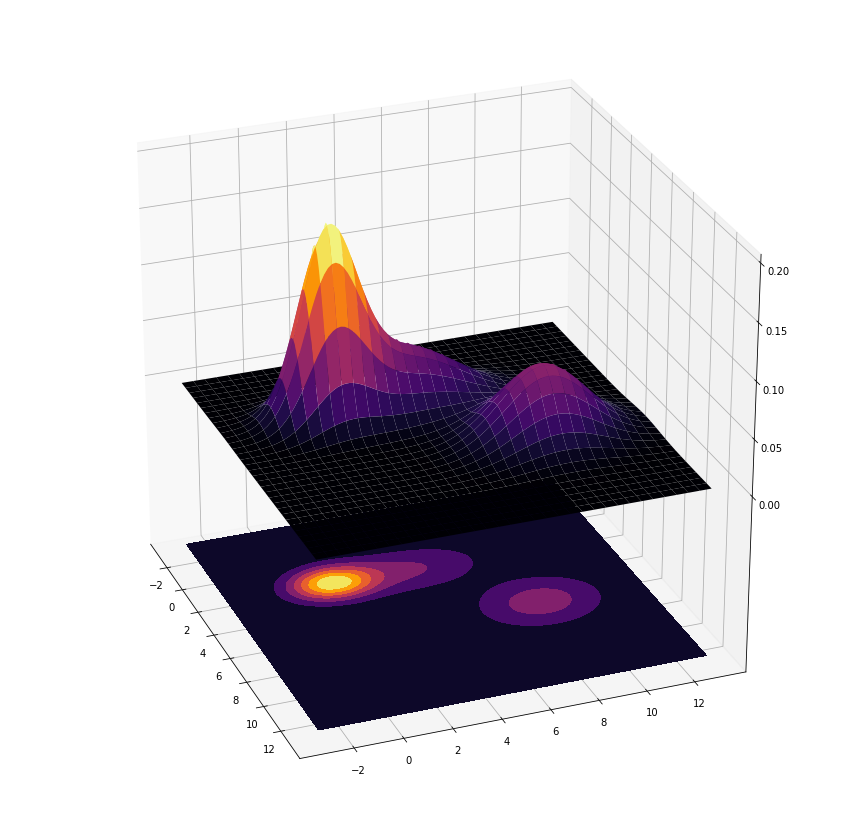

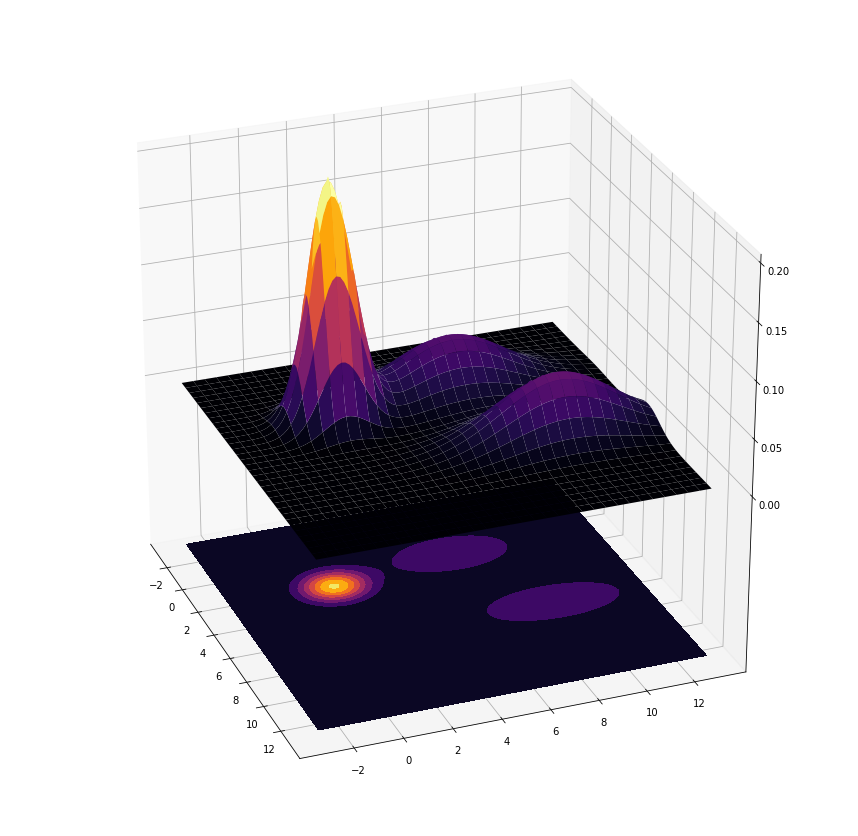

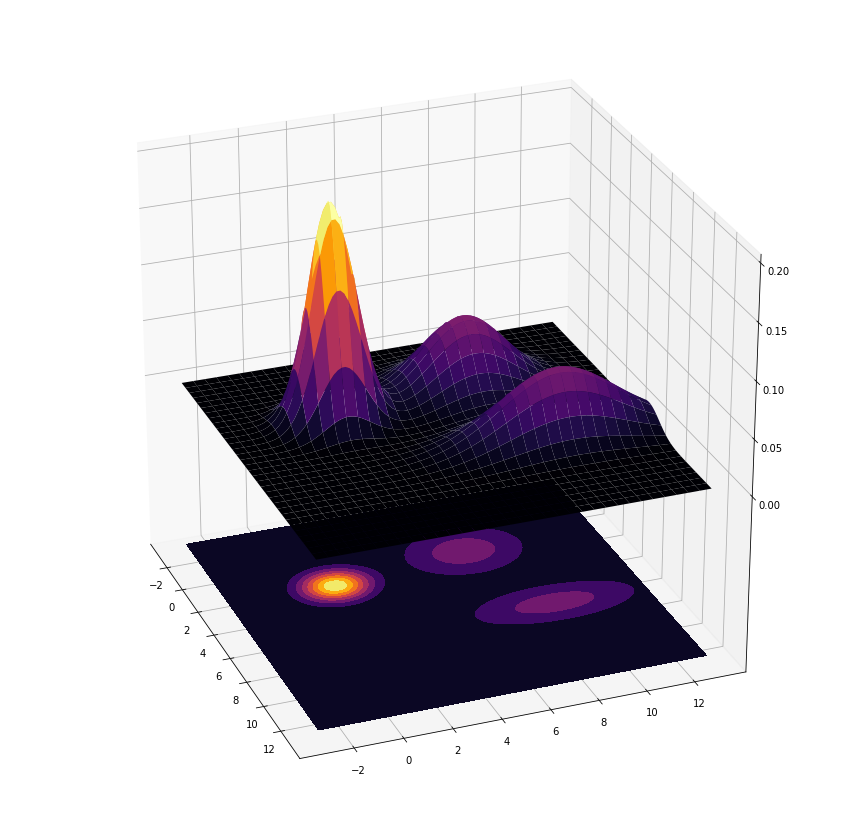

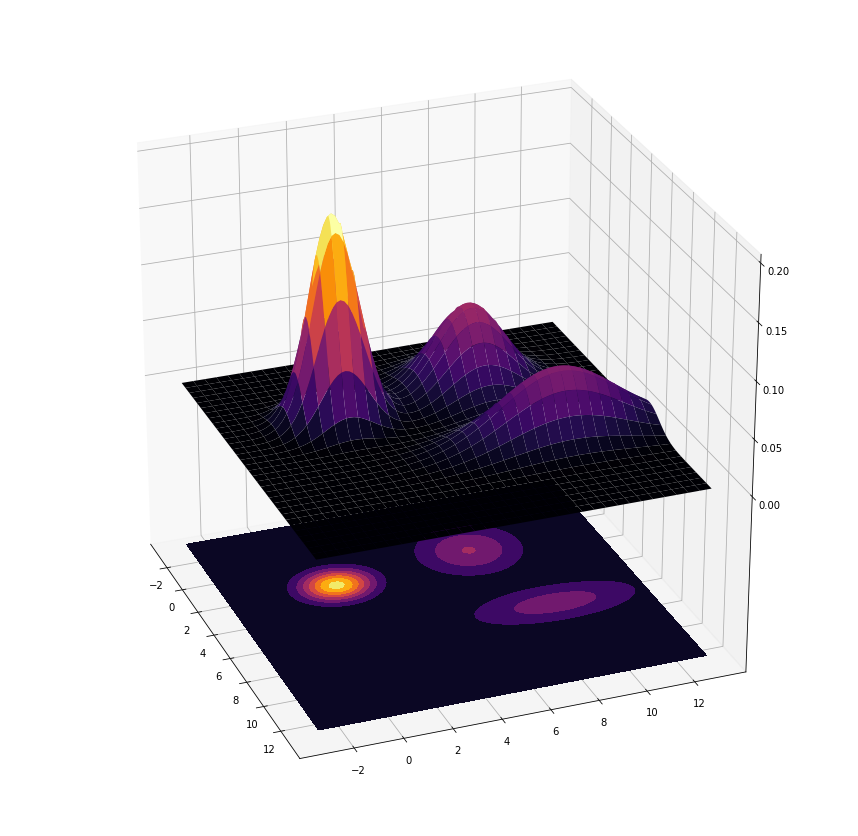

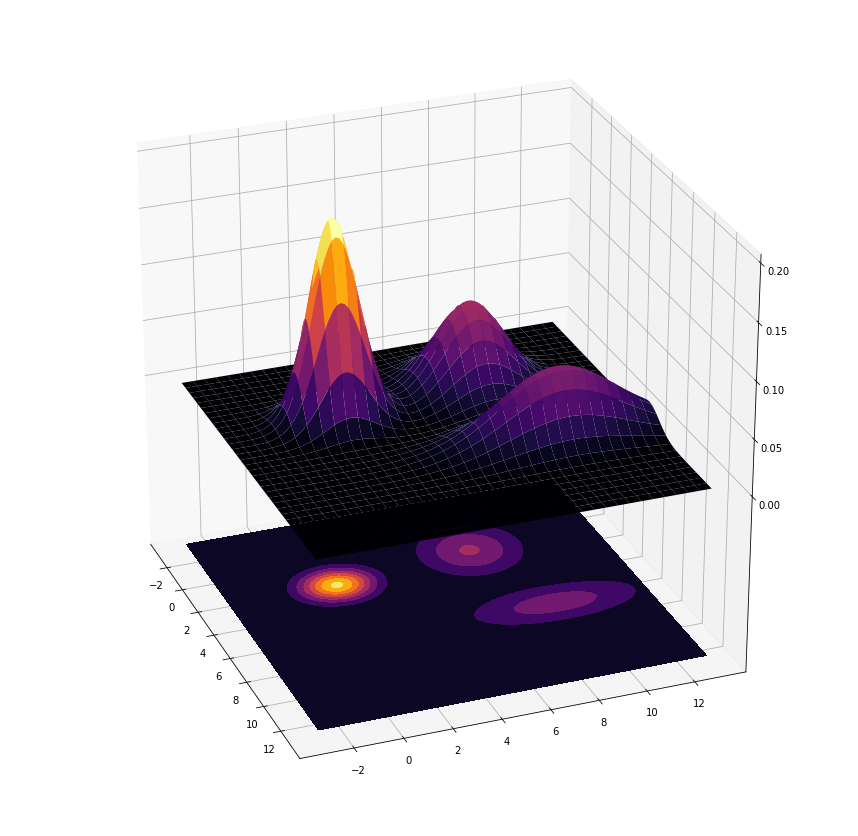

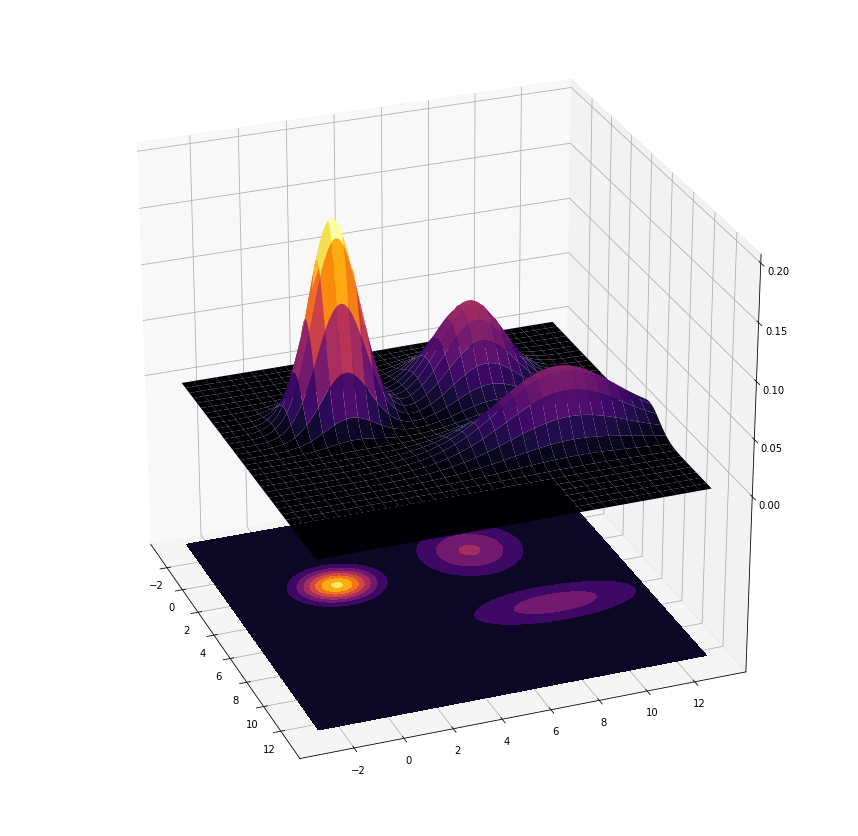

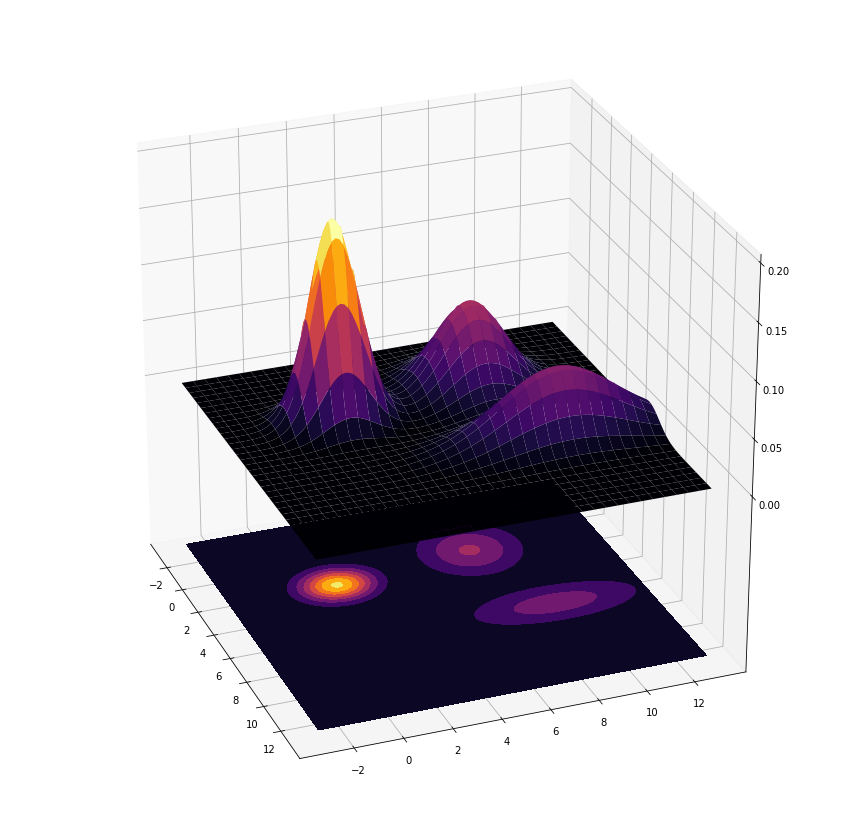

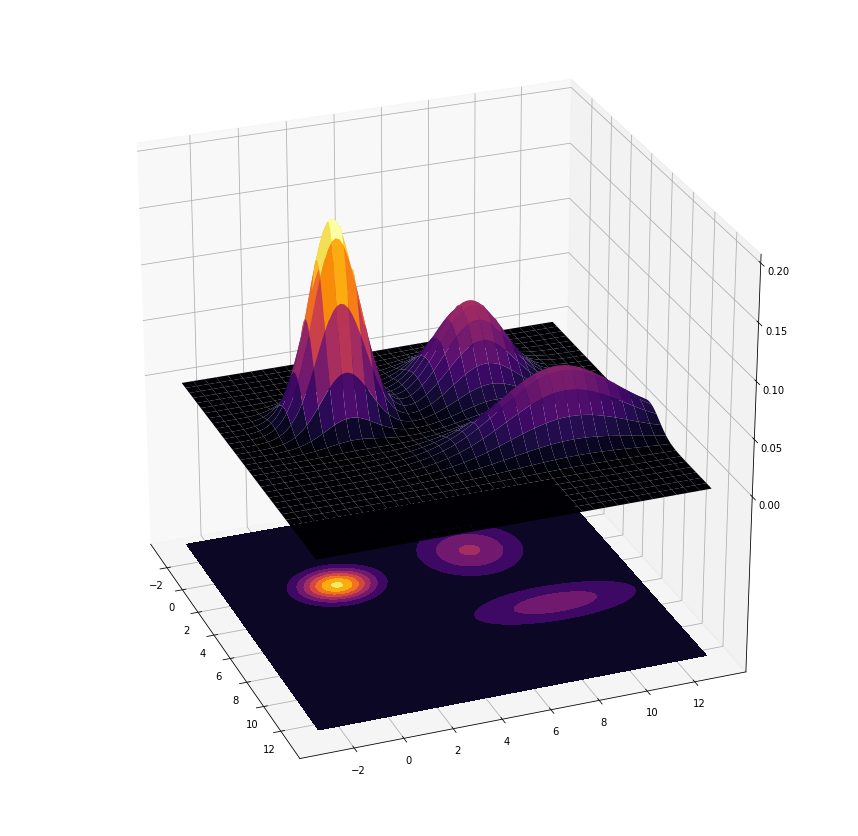

In [11]:
plt.ion() # Ploting

# Stoping Criterions
max_iter = 1000
prev_cost = float('inf')
thresh = 1e-4

# training loop
for i in tqdm(range(max_iter)):

    # (E-step) Calculate Posterior = mixture membership w
    likelihoods = get_k_likelihoods(data, mu, var)  # likelihoods p(x|z) under the parameters mu, var, phi 
    w = get_posteriors(likelihoods,phi)             # posterior P(Z|X)
    
    # (M-Step) Update parameters using w
    mu, var, phi = get_parameters(data, w)
    
    
    # Ploting 
    if i % 2 == 0:
        plot_density(mu, var, phi, N=100, X_range=(-3, 13), Y_range=(-3, 13), i=i)
    
    
    # Calculate Current log-likelihood
    sum_over_k = likelihoods*phi.unsqueeze(1).sum(dim=0)      # get weight probability of each point under each k
    sum_over_m = torch.sum(torch.log(sum_over_k + 1e-6))      # take log probability over each example `m`
    cost = - sum_over_m / likelihoods.size(1)

    # Exit Condition
    diff = prev_cost - cost
    if np.abs(diff) < thresh:
         break
    prev_cost = cost
    
plt.ioff() # Ploting

## 4. Results

In [12]:
print(mu)  # True: [7, 9], [1.5, 7.5], [2.5, 1.5]
print(var) # True: [1, 6], [2, 2],  [.8, 1] 
print(phi) # True: 0.333, 0.333, 0.333

tensor([[6.9479, 9.1443],
        [2.4581, 1.5414],
        [1.5962, 7.5780]])
tensor([[1.0073, 6.1504],
        [0.7598, 1.0327],
        [2.0506, 2.0158]])
tensor([0.3317, 0.3365, 0.3319])
